In [110]:
import random
import math
import matplotlib.pyplot as plt
from deap import base,  benchmarks, creator, tools
import array
import numpy
import copy



In [ ]:


def generateES(icls, scls, size, imin, imax, smin, smax):
    ind = icls(random.uniform(imin, imax) for _ in range(size))
    ind.strategy = scls(random.uniform(smin, smax) for _ in range(size))
    return ind

def checkStrategy(minstrategy):
    def decorator(func):
        def wrappper(*args, **kargs):
            children = func(*args, **kargs)
            for child in children:
                for i, s in enumerate(child.strategy):
                    if s < minstrategy:
                        child.strategy[i] = minstrategy
            return children
        return wrappper
    return decorator


def ES_algo( toolbox,mu, lamda_, cxpb=0.6, mutpb=0.3, max_iter=100):
    
    # Init mu number of parents 
    pop = toolbox.population(n=mu)

    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("std", numpy.std)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)

    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "std", "min", "avg", "max"


    for ind in pop:
        ind.fitness.values = toolbox.evaluate(ind)

    for gen in range(1, max_iter +1):
        
        offsprings = []

        while len(offsprings) < lamda_:
            # Probability of selecting parents
            # Creats offspring
            if random.random() < cxpb:
                p1, p2 = random.sample(pop,2)
                children = toolbox.mate(p1,p2)
            else:
                parent = random.choice(pop)
                children = [parent]

            for child in children:
                if random.random() < mutpb:
                    toolbox.mutate(child)

                child.fitness.values = toolbox.evaluate(child)

            offsprings.extend(children)


            # Select best  mu indivudals
        pop = tools.selBest(offsprings, mu)

        hof.update(pop)
        record = stats.compile(pop)
        logbook.record(gen=gen, evals=len(pop), **record)
        print(f"Gen {gen}: {record}")
        

    return pop, hof, logbook


# Will do adaptive eso
def ES(dimension, fitness, mu, lambda_, l_bound, h_bound, min_mut, max_mut, max_iter=100):

    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", array.array, typecode="d", fitness=creator.FitnessMin, strategy=None)
    creator.create("Strategy", array.array, typecode="d")

    toolbox = base.Toolbox()
    toolbox.register("attr_float", random.uniform, l_bound, h_bound)
    toolbox.register("individual", generateES, creator.Individual, creator.Strategy,
    dimension, l_bound, h_bound, min_mut, max_mut)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", tools.cxESBlend, alpha=0.1)

    # This samples from a normal distribution
    toolbox.register("mutate", tools.mutESLogNormal, c=0.1, indpb=0.05)
    toolbox.register("select", tools.selRandom, k=3)
    toolbox.register("evaluate", fitness)

    toolbox.decorate("mate", checkStrategy(min_mut))
    toolbox.decorate("mutate", checkStrategy(min_mut))

    (pop, hof, logbook) = ES_algo(toolbox, mu, lambda_, max_iter=max_iter)


    return logbook, hof


In [ ]:
class Individual_EP:
    def __init__(self,l_bound, h_bound, min_mut,max_mut, dimension):

        self.x = [random.uniform(l_bound, h_bound) for _ in range(dimension)]

        self.mut_lev = [random.uniform(min_mut, max_mut) for _ in range(dimension)]

        self.fitness = float('inf') 

        self.tau =  1 / math.sqrt(2 * math.sqrt(dimension))

        self.tau_prime = 1 / math.sqrt(2 * dimension)


    def update_mut_level(self):
        
        a = numpy.random.normal(0,1)

        for i in range(len(self.mut_lev)):

            b = numpy.random.normal(0,1)

            old_mut = self.mut_lev[i]

            self.mut_lev[i] = old_mut * math.exp(self.tau_prime * a + self.tau * b)

    def update_x(self, dist):

        self.update_mut_level()

        for i in range(len(self.x)):
            old_x = self.x[i]

            self.x[i] = old_x + self.mut_lev[i] * dist[i]

        
    def copy(self):

        copy_ind =  copy.deepcopy(self)
        copy_ind.fitness = float('inf')

        return copy_ind
    



In [119]:
def ind_mutation(ind, dimension):
    ind_1 = ind.copy()
    ind_2 = ind.copy()

    normal_dist = numpy.random.normal(size=dimension)
    cauchy_samples = numpy.random.standard_cauchy(size=dimension)

    ind_1.update_x(normal_dist)
    ind_2.update_x(cauchy_samples)

    return (ind_1, ind_2)

def select_best_ind(ind_1, ind_2, fitness):
    ind_1.fitness = fitness(ind_1.x)
    ind_2.fitness = fitness(ind_2.x)
 
    if ind_1.fitness <= ind_2.fitness:
        return ind_1
    else:
        return ind_2
    

def EP(dimension, pop_size,fitness, l_bound, h_bound, min_mut, max_mut, max_iter=100):

    # Create init pop
    pop = [Individual_EP(l_bound, h_bound,min_mut, max_mut, dimension ) for _ in range(pop_size)]
    
    # Calc inital fitness
    for p in pop:
        p.fitness = fitness(p.x)

    for i in range(1, max_iter+1):
        
        offspring = []

        for ind in pop:

            (ind_1, ind_2) = ind_mutation(ind, dimension)

            ind = select_best_ind(ind_1, ind_2, fitness)

            offspring.append(ind)

        combined = pop + offspring

        combined.sort(key=lambda ind: ind.fitness)
        pop = combined[:pop_size]

    return pop



In [102]:
def rosenbrock_fitness(x):
    D = len(x)

    total = 0.0
    
    for i in range(D-1):
        total += 100 * (x[i+1] - x[i]**2)**2 + (x[i] - 1)**2
    return (total,)

def griewank_fitness(x):

    sum_term = sum(xi**2 / 4000 for xi in x)

    prod_term = 1.0

    for i, xi in enumerate(x, start=1):
        prod_term *= math.cos(xi / math.sqrt(i))
    return (sum_term - prod_term + 1,)

In [103]:
def plot_fitness(fitnesses, title="Fitness Over Epochs"):
    plt.figure(figsize=(10, 6))
    plt.plot(fitnesses, label="Fitness")
    plt.xlabel("Epoch")
    plt.ylabel("Fitness")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [123]:
pop = EP(30, 50, rosenbrock_fitness,-30, 30, 0.1, 1)

AttributeError: 'Individual_EP' object has no attribute 'copy'

Gen 1: {'avg': np.float64(159868811.00391543), 'std': np.float64(59549594.99462879), 'min': np.float64(80817770.9694691), 'max': np.float64(267906134.00365746)}
Gen 2: {'avg': np.float64(33747987.43993588), 'std': np.float64(22147290.319405835), 'min': np.float64(8640787.195152689), 'max': np.float64(83189608.45441857)}
Gen 3: {'avg': np.float64(11726963.079180662), 'std': np.float64(3257950.8114155894), 'min': np.float64(5942666.357914205), 'max': np.float64(18984449.789401185)}
Gen 4: {'avg': np.float64(3220830.8805360286), 'std': np.float64(895446.6976748528), 'min': np.float64(2496800.099791231), 'max': np.float64(5106577.5951018175)}
Gen 5: {'avg': np.float64(1975533.3907918336), 'std': np.float64(375697.9667662596), 'min': np.float64(1492013.2800693538), 'max': np.float64(2400542.0875359294)}
Gen 6: {'avg': np.float64(1847195.537397184), 'std': np.float64(15637.16493803837), 'min': np.float64(1813645.9855925748), 'max': np.float64(1860339.762771243)}
Gen 7: {'avg': np.float64(197

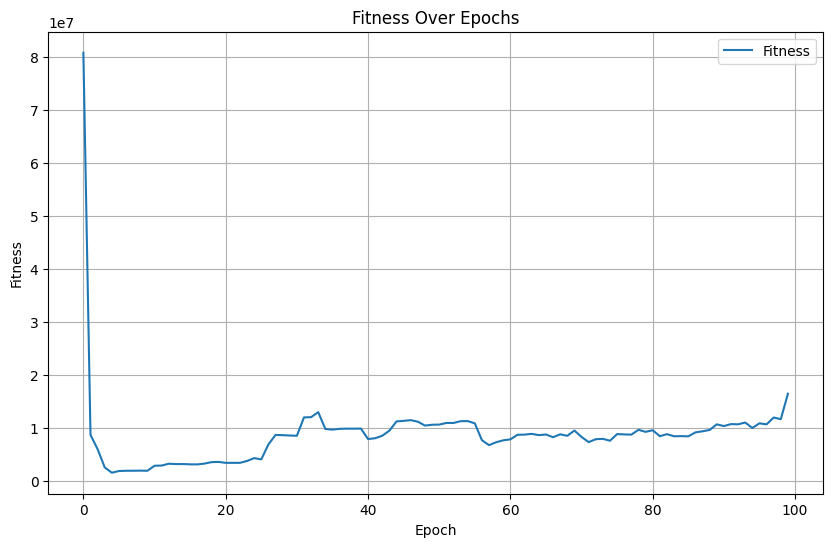

In [104]:
(logbook,hfa) = ES(30,rosenbrock_fitness, 30, 50, -30, 30, 0.1, 1)

best_fitness_per_gen = logbook.select("min")

plot_fitness(best_fitness_per_gen)